In [4]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Vermont

## Load VEST File

In [5]:
vest_vt_20 = gp.read_file("./raw-from-source/VEST/vt_2020/vt_2020.shp")

<AxesSubplot:>

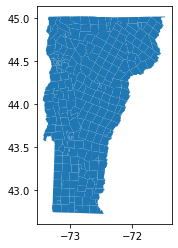

In [6]:
vest_vt_20.plot()

In [7]:
print(vest_vt_20)

    STATEFP20 COUNTYFP20                   NAME20  G20PREDBID  G20PRERTRU  \
0          50        001                  Whiting         124          84   
1          50        001                New Haven         732         396   
2          50        001                Salisbury         393         258   
3          50        001                   Orwell         367         351   
4          50        001              Ferrisburgh        1202         561   
..        ...        ...                      ...         ...         ...   
279        50        019         Troy - Orleans 2          98         115   
280        50        025            Westminster 4        1244         403   
281        50        025            Westminster 3          59          26   
282        50        025   Whitingham - Windham 6         372         319   
283        50        025  Whitingham - Bennington          25          21   

     G20PRELJOR  G20PREGHAW  G20PREIWES  G20PREOOTH  G20PREOSAN  ...  \
0  

## Election Results

### VEST Documentation

Election results from the Vermont Secretary of State (https://electionarchive.vermont.gov/)  


Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2019 American Community Survey as 2020 Census results are not yet available at the township level. (Averill-Canaan, Buel's Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

G20PREDBID - Joseph R. Biden (Democratic Party)
G20PRERTRU - Donald J. Trump (Republican Party)
G20PRELJOR - Jo Jorgensen (Libertarian Party)
G20PREGHAW - Howie Hawkins (Green Party)
G20PREIWES - Kanye West (Independent)
G20PREOOTH - Other Candidates on Ballot
G20PREOSAN - Bernie Sanders (Write-in)
G20PREOWRI - Other Write-in Candidates

G20HALDWEL - Peter Welch (Democratic Party)
G20HALDRBE - Miriam Berry (Republican Party)
G20HALCHEL - Christopher Helali (Communisty Party)
G20HALIBEC - Peter R. Becker (Independent)
G20HALIHOR - Marcia Horne (Independent)
G20HALIORR - Shawn Orr (Independent)
G20HALITRU - Jerry Trudell (Independent)
G20HALOWRI - Write-in Votes

G20GOVDZUC - David Zuckerman (Progressive Party and Democratic Party (fusion candidate))
G20GOVRSCO - Phil Scott (Republican Party)
G20GOVIHOY - Kevin Hoyt (Independent)
G20GOVTPEY - Emily Peyton (Truth Matters Pary)
G20GOVIWHI - Erynn Hazlett Whitney (Independent)
G20GOVIBIL - Wayne Billado III (Independent)
G20GOVIDEV - Michael Devost (Independent)
G20GOVUDIC - Charly Dickerson (Unaffiliated)
G20GOVOWRI - Write-in Votes

G20LTGDGRA - Molly Gray (Democratic Party)
G20LTGRMIL - Scott Milne (Republican Party)
G20LTGPERI - Cris Ericson (Progressive Party)
G20LTGIBIL - Wayne Billado III (Independent)
G20LTGBCOR - Ralph Corbo (Banigh the F-35s Party)
G20LTGOWRI - Write-in Votes

G20ATGDDON - T.J. Donovan (Democratic Party)
G20ATGRPAI - H. Brooke Paige (Republican Party)
G20ATGPERI - Cris Ericson (Progressive Party)
G20ATGOWRI - Write-in Votes

G20SOSDCON - Jim Condos (Democratic Party)
G20SOSRPAI - H. Brooke Paige (Republican Party)
G20SOSPERI - Cris Ericson (Progressive Party)
G20SOSISMI - Pamala Smith (Independent)
G20SOSOWRI - Write-in Votes

G20TREDPEA - Beth Pearce (Democratic Party)
G20TRERBRA - Barolyn Whitney Branagan (Republican Party)
G20TREPERI - Cris Ericson (Progressive Party)
G20TREIWRI - Alex Wright (Independent)
G20TREOWRI - Write-in Votes

G20AUDOHOF - Doug Hoffer (Democratic Party and Republican Party (fusion candidate))
G20AUDPERI - Cris Ericson (Progressive Party)
G20AUDOWRI - Write-in Votes

### Load Source Files

In [8]:
all_files = os.listdir("./raw-from-source/Election_Results/")
li = []
for file in all_files:
    if file  != ".DS_Store":
        ref = "./raw-from-source/Election_Results/"
        file_ref = ref+file
        file_prev = pd.read_csv(file_ref,engine='python',index_col=None)
        #Only keep the City/Town and Pct columns in one file, as they are duplicated
        #Delete unused columns in others
        if file != 'VT_Elections_Database__2020_Treasurer_General_Election_including_precincts.csv':
            file_prev = file_prev.drop(['City/Town', 'Ward', 'Pct','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
            file_prev = file_prev.drop([0])
        else:
            file_prev = file_prev.drop(['Ward','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
            file_prev = file_prev.drop([0])
        for col in file_prev.columns:
            file_prev.rename(columns={col:col+"-"+file[28:40]},inplace=True)
        li.append(file_prev)
    
#Define the dataframe, note we are add the loaded dataframes next to one another and not below
frame = pd.concat(li, axis=1, ignore_index=False)

### Clean up the election results

#### Rename and reorder the columns to match VEST

typo on 'Barolyn Whitney Branagan'

In [9]:
print(frame.columns)

Index(['City/Town-Treasurer_Ge', 'Pct-Treasurer_Ge',
       'Beth Pearce-Treasurer_Ge', 'Carolyn Whitney Branagan-Treasurer_Ge',
       'Alex Wright-Treasurer_Ge', 'Cris Ericson-Treasurer_Ge',
       'Write-Ins-Treasurer_Ge', 'T.J. Donovan-Attorney_Gen',
       'H. Brooke Paige-Attorney_Gen', 'Cris Ericson-Attorney_Gen',
       'Write-Ins-Attorney_Gen', 'Doug Hoffer-Auditor_Gene',
       'Cris Ericson-Auditor_Gene', 'Write-Ins-Auditor_Gene',
       'Molly Gray-Lieutenant_G', 'Scott Milne-Lieutenant_G',
       'Cris Ericson-Lieutenant_G', 'Wayne Billado, III-Lieutenant_G',
       'Ralph Corbo-Lieutenant_G', 'David Zuckerman-Lieutenant_G',
       'Write-Ins-Lieutenant_G', 'Phil Scott-Governor_Gen',
       'David Zuckerman-Governor_Gen', 'Kevin Hoyt-Governor_Gen',
       'Emily Peyton-Governor_Gen', 'Erynn Hazlett Whitney-Governor_Gen',
       'Wayne Billado, III-Governor_Gen', 'Michael A. Devost-Governor_Gen',
       'Charly Dickerson-Governor_Gen', 'Write-Ins-Governor_Gen',
       'Pete

In [10]:
temp_names = ['NAME20', 'NAME20_1',
"G20TREDPEA",
"G20TRERBRA",
"G20TREIWRI",
"G20TREPERI",
"G20TREOWRI",
"G20ATGDDON",
"G20ATGRPAI",
"G20ATGPERI",
"G20ATGOWRI",
"G20AUDOHOF",
"G20AUDPERI", 
"G20AUDOWRI",
"G20LTGDGRA",
"G20LTGRMIL",
"G20LTGPERI",
"G20LTGIBIL",
"G20LTGBCOR",
"G20LTGOWRI_to_add",
"G20LTGOWRI",
"G20GOVRSCO",
"G20GOVDZUC",
"G20GOVIHOY",
"G20GOVTPEY",
"G20GOVIWHI",
"G20GOVIBIL",
"G20GOVIDEV",
"G20GOVUDIC",
"G20GOVOWRI",
"G20HALDWEL",
"G20HALDRBE",
 "G20HALIBEC",
"G20HALIHOR",
"G20HALCHEL",
"G20HALIORR",
"G20HALITRU",
"G20HALOWRI",
"G20PREDBID",
"G20PRERTRU",
"G20PRELJOR",
"G20PREGHAW",
"G20PREIWES",
"G20PREOOTH_add_1",
 "G20PREOOTH_add_2",
"G20PREOSAN",
  "G20PREOOTH_add_3",
 "G20PREOOTH_add_4",
 "G20PREOOTH_add_5",
"G20PREOOTH_add_6",
 "G20PREOOTH_add_7",
 "G20PREOOTH_add_8",
"G20PREOOTH_add_9",
 "G20PREOOTH_add_10",
 "G20PREOOTH_add_11",
"G20PREOOTH_add_12",
 "G20PREOOTH_add_13",
 "G20PREOOTH_add_14",
"G20PREOOTH_add_15",
"G20PREOOTH_add_16",
"G20PREOWRI",
"G20SOSDCON",
"G20SOSRPAI",
"G20SOSISMI",
 "G20SOSPERI",
"G20SOSOWRI"]
    
frame.columns = temp_names

In [11]:
for race in temp_names:
    if race not in ['NAME20', 'NAME20_1']:
        frame[race]=frame[race].astype(str)
        frame[race]=frame[race].apply(lambda x: x.replace(',',''))
        frame[race]=frame[race].astype(float)
        frame[race]=frame[race].astype(int)

In [12]:
frame.columns

Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR',
       'G20LTGOWRI_to_add', 'G20LTGOWRI', 'G20GOVRSCO', 'G20GOVDZUC',
       'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL', 'G20GOVIDEV',
       'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI',
       'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES',
       'G20PREOOTH_add_1', 'G20PREOOTH_add_2', 'G20PREOSAN',
       'G20PREOOTH_add_3', 'G20PREOOTH_add_4', 'G20PREOOTH_add_5',
       'G20PREOOTH_add_6', 'G20PREOOTH_add_7', 'G20PREOOTH_add_8',
       'G20PREOOTH_add_9', 'G20PREOOTH_add_10', 'G20PREOOTH_add_11',
       'G20PREOOTH_add_12', 'G20PREOOTH_add_13', 'G20PREOOTH_add_14',


In [13]:
frame['G20PREOOTH']=0
frame["G20LTGOWRI"]+=frame["G20LTGOWRI_to_add"]
for val in range(1,17):
    name_string = 'G20PREOOTH_add_'+str(val)
    frame['G20PREOOTH']+=frame[name_string]

In [14]:
frame = frame[['NAME20', 'NAME20_1',
"G20TREDPEA",
"G20TRERBRA",
"G20TREIWRI",
"G20TREPERI",
"G20TREOWRI",
"G20ATGDDON",
"G20ATGRPAI",
"G20ATGPERI",
"G20ATGOWRI",
"G20AUDOHOF",
"G20AUDPERI", 
"G20AUDOWRI",
"G20LTGDGRA",
"G20LTGRMIL",
"G20LTGPERI",
"G20LTGIBIL",
"G20LTGBCOR",
"G20LTGOWRI_to_add",
"G20LTGOWRI",
"G20GOVRSCO",
"G20GOVDZUC",
"G20GOVIHOY",
"G20GOVTPEY",
"G20GOVIWHI",
"G20GOVIBIL",
"G20GOVIDEV",
"G20GOVUDIC",
"G20GOVOWRI",
"G20HALDWEL",
"G20HALDRBE",
 "G20HALIBEC",
"G20HALIHOR",
"G20HALCHEL",
"G20HALIORR",
"G20HALITRU",
"G20HALOWRI",
"G20PREDBID",
"G20PRERTRU",
"G20PRELJOR",
"G20PREGHAW",
"G20PREIWES",
"G20PREOOTH",
"G20PREOSAN",
"G20PREOWRI",
"G20SOSDCON",
"G20SOSRPAI",
"G20SOSISMI",
 "G20SOSPERI",
"G20SOSOWRI"]]

In [15]:
print(frame.columns)

Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR',
       'G20LTGOWRI_to_add', 'G20LTGOWRI', 'G20GOVRSCO', 'G20GOVDZUC',
       'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL', 'G20GOVIDEV',
       'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI',
       'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES',
       'G20PREOOTH', 'G20PREOSAN', 'G20PREOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSISMI', 'G20SOSPERI', 'G20SOSOWRI'],
      dtype='object')


In [16]:
data_columns = ['G20PRELJOR', 'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN',
       'G20PREOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALCHEL', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI', 'G20GOVDZUC',
       'G20GOVRSCO', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL',
       'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20LTGDGRA', 'G20LTGRMIL',
       'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI', 'G20ATGDDON',
       'G20ATGRPAI', 'G20ATGPERI', 'G20ATGOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSPERI', 'G20SOSISMI', 'G20SOSOWRI', 'G20TREDPEA', 'G20TRERBRA',
       'G20TREPERI', 'G20TREIWRI', 'G20TREOWRI', 'G20AUDOHOF', 'G20AUDPERI',
       'G20AUDOWRI']

In [17]:
print(vest_vt_20.columns)

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN',
       'G20PREOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALCHEL', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI', 'G20GOVDZUC',
       'G20GOVRSCO', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL',
       'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20LTGDGRA', 'G20LTGRMIL',
       'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI', 'G20ATGDDON',
       'G20ATGRPAI', 'G20ATGPERI', 'G20ATGOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSPERI', 'G20SOSISMI', 'G20SOSOWRI', 'G20TREDPEA', 'G20TRERBRA',
       'G20TREPERI', 'G20TREIWRI', 'G20TREOWRI', 'G20AUDOHOF', 'G20AUDPERI',
       'G20AUDOWRI', 'geometry'],
      dtype='object')


#### Clean the column data types

#### Remove rows that count total votes

In [18]:
frame = frame[frame['NAME20']!="TOTALS"]

#### Compare race-wide election totals against VEST

In [19]:
frame

,NAME20,NAME20_1,G20TREDPEA,G20TRERBRA,G20TREIWRI,G20TREPERI,G20TREOWRI,G20ATGDDON,G20ATGRPAI,G20ATGPERI,...,G20PREGHAW,G20PREIWES,G20PREOOTH,G20PREOSAN,G20PREOWRI,G20SOSDCON,G20SOSRPAI,G20SOSISMI,G20SOSPERI,G20SOSOWRI
1,Addison,NaN,372,404,33,20,0,500,317,25,...,2,6,19,1,3,424,357,43,16,0
2,Albany,NaN,255,213,16,28,0,301,184,27,...,2,0,10,2,1,275,189,29,20,0
3,Alburgh,NaN,436,508,61,23,2,589,396,45,...,3,4,8,2,3,477,405,127,23,3
4,Andover,NaN,180,135,12,24,0,211,116,15,...,0,2,7,1,2,198,115,16,21,0
5,Arlington,NaN,739,492,75,62,2,853,465,63,...,3,3,15,1,2,792,464,91,51,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,Wolcott,NaN,501,277,53,31,1,578,261,43,...,2,6,14,1,2,527,278,55,23,0
272,Woodbury,NaN,336,178,16,29,0,364,172,26,...,3,0,8,2,0,352,182,16,19,0
273,Woodford,NaN,85,80,11,8,2,95,81,7,...,1,0,0,0,0,87,78,20,0,1
274,Woodstock,NaN,1293,485,80,80,0,1458,394,78,...,6,4,18,5,11,1365,422,112,64,3


In [20]:
print("Races with differences will be printed below:")
for race in data_columns:
    if (sum(vest_vt_20[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_20[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_20[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All other races are equal")

Races with differences will be printed below:

All other races are equal


### Following VEST documentation, allocate votes to the four unorganized towns

#### Documentation

> Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2019 American Community Survey as 2020 Census results are not yet available at the township level. (Averill-Canaan, Buel's Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

#### Add empty precincts to the dataframe (will allocate votes afterwards)

In [21]:
new_df = pd.DataFrame([["Averill","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Buels Gore","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Ferdinand","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Glastenbury","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

#### Load the ACS data

In [22]:
acs_allocating_votes = pd.read_csv("./raw-from-source/ACS/ACSST5Y2019.S0101_2021-07-20T203240/ACSST5Y2019.S0101_data_with_overlays_2021-07-20T203200.csv")        

In [23]:
#Clean up the header
acs_allocating_votes.columns = acs_allocating_votes.iloc[0]
acs_allocating_votes = acs_allocating_votes.drop([0])

#Grab needed columns
acs_allocating_votes = acs_allocating_votes[["Geographic Area Name",'Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over']]

#Rename columns
acs_allocating_votes.columns=["Place","VAP Estimate"]

#Clean columns
acs_allocating_votes["VAP Estimate"]=acs_allocating_votes["VAP Estimate"].astype(float)

#Define a "ratio" column, fill it below with the percentage of voters from the area where votes were counted
acs_allocating_votes["ratio"]=0

In [24]:
print(acs_allocating_votes)

                                          Place  VAP Estimate  ratio
1  Glastenbury town, Bennington County, Vermont           0.0      0
2   Shaftsbury town, Bennington County, Vermont        2590.0      0
3        Buels gore, Chittenden County, Vermont          17.0      0
4   Huntington town, Chittenden County, Vermont        1592.0      0
5           Averill town, Essex County, Vermont          10.0      0
6          Brighton town, Essex County, Vermont         986.0      0
7            Canaan town, Essex County, Vermont         718.0      0
8         Ferdinand town, Essex County, Vermont          21.0      0


In [25]:
#Glastenbury (from Shaftsbury)
acs_allocating_votes.iloc[0,2]=acs_allocating_votes.iloc[0,1]/acs_allocating_votes.iloc[1,1]
#Buels (from Huntington)
acs_allocating_votes.iloc[2,2]=acs_allocating_votes.iloc[2,1]/acs_allocating_votes.iloc[3,1]
#Averill (from Canaan)
acs_allocating_votes.iloc[4,2]=acs_allocating_votes.iloc[4,1]/acs_allocating_votes.iloc[6,1]
#Ferdinand (from Brighton)
acs_allocating_votes.iloc[7,2]=acs_allocating_votes.iloc[7,1]/acs_allocating_votes.iloc[5,1]

print(acs_allocating_votes)

                                          Place  VAP Estimate     ratio
1  Glastenbury town, Bennington County, Vermont           0.0  0.000000
2   Shaftsbury town, Bennington County, Vermont        2590.0  0.000000
3        Buels gore, Chittenden County, Vermont          17.0  0.010678
4   Huntington town, Chittenden County, Vermont        1592.0  0.000000
5           Averill town, Essex County, Vermont          10.0  0.013928
6          Brighton town, Essex County, Vermont         986.0  0.000000
7            Canaan town, Essex County, Vermont         718.0  0.000000
8         Ferdinand town, Essex County, Vermont          21.0  0.021298


#### Allocate votes to Averill from Canaan

In [26]:
for race in data_columns:
    frame.loc[frame["NAME20"]=="Averill",race] = round(frame.loc[frame["NAME20"]=="Canaan",race].values[0]*0.013928,0).astype(int)
    frame.loc[frame["NAME20"]=="Canaan",race]= round(frame.loc[frame["NAME20"]=="Canaan",race].values[0]*(1-0.013928),0).astype(int)
print(frame.loc[frame["NAME20"]=="Averill"])
print(frame.loc[frame["NAME20"]=="Canaan"])

      NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
275  Averill                    3           3           1           0   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
275           0           4           2           1  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
275           0           0           0           0           3           3   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
275           1           0           0  

[1 rows x 51 columns]
    NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
47  Canaan      NaN         192         203          54           7   

    G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
47           1         251         169          36  ...           0   

    G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
47           0           7           1           3         194         206   


#### Allocate votes to Buels Gore from Huntington

In [27]:
frame.loc[frame["NAME20"]=="Huntington"]

for race in data_columns:
    frame.loc[frame["NAME20"]=="Buels Gore",race] = round(frame.loc[frame["NAME20"]=="Huntington",race].values[0]*0.010678,0).astype(int)
    frame.loc[frame["NAME20"]=="Huntington",race]= round(frame.loc[frame["NAME20"]=="Huntington",race].values[0]*(1-0.010678),0).astype(int)
print(frame.loc[frame["NAME20"]=="Buels Gore"])
print(frame.loc[frame["NAME20"]=="Huntington"])

         NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
276  Buels Gore                   10           3           1           1   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
276           0          11           3           1  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
276           0           0           0           0          10           3   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
276           1           0           0  

[1 rows x 51 columns]
         NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
108  Huntington      NaN         889         298          70          62   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
108           0        1049         234          58  ...           6   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
108           5          12           3           9        

#### Allocate votes to Ferdinand from Brighton

In [28]:
for race in data_columns:
    frame.loc[frame["NAME20"]=="Ferdinand",race] = round(frame.loc[frame["NAME20"]=="Brighton",race].values[0]*0.021298,0).astype(int)
    frame.loc[frame["NAME20"]=="Brighton",race]= round(frame.loc[frame["NAME20"]=="Brighton",race].values[0]*(1-0.021298),0).astype(int)
print(frame.loc[frame["NAME20"]=="Ferdinand"])
print(frame.loc[frame["NAME20"]=="Brighton"])

        NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
277  Ferdinand                    5           6           1           0   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
277           0           6           5           1  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
277           0           0           0           0           5           6   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
277           1           0           0  

[1 rows x 51 columns]
      NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
30  Brighton      NaN         224         270          48          17   

    G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
30           0         269         233          23  ...           2   

    G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
30           3           4           2           1         238        

#### Allocate votes to Glastenbury from Shaftsbury

In [29]:
for race in data_columns:
    frame.loc[frame["NAME20"]=="Glastenbury",race] = round(frame.loc[frame["NAME20"]=="Shaftsbury",race].values[0]*0,0).astype(int)
    frame.loc[frame["NAME20"]=="Shaftsbury",race]= round(frame.loc[frame["NAME20"]=="Shaftsbury",race].values[0]*(1-0),0).astype(int)
print(frame.loc[frame["NAME20"]=="Glastenbury"])
print(frame.loc[frame["NAME20"]=="Shaftsbury"])

          NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
278  Glastenbury                    0           0           0           0   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
278           0           0           0           0  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
278           0           0           0           0           0           0   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
278           0           0           0  

[1 rows x 51 columns]
         NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
191  Shaftsbury      NaN        1114         775         106          84   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
191           3        1228         756          91  ...           7   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
191          11          20           1           3      

#### Compare race-wide election totals against VEST to make sure totals still match

In [30]:
for race in data_columns:
    if (sum(vest_vt_20[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_20[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_20[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All races are equal")


All races are equal


In [31]:
print(vest_vt_20)

vest_vt_20["join_col"] = vest_vt_20["NAME20"]


    STATEFP20 COUNTYFP20                   NAME20  G20PREDBID  G20PRERTRU  \
0          50        001                  Whiting         124          84   
1          50        001                New Haven         732         396   
2          50        001                Salisbury         393         258   
3          50        001                   Orwell         367         351   
4          50        001              Ferrisburgh        1202         561   
..        ...        ...                      ...         ...         ...   
279        50        019         Troy - Orleans 2          98         115   
280        50        025            Westminster 4        1244         403   
281        50        025            Westminster 3          59          26   
282        50        025   Whitingham - Windham 6         372         319   
283        50        025  Whitingham - Bennington          25          21   

     G20PRELJOR  G20PREGHAW  G20PREIWES  G20PREOOTH  G20PREOSAN  ...  \
0  

In [32]:
frame["NAME20_1"] =frame["NAME20_1"].fillna("")

In [33]:
print(frame.columns)

Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR',
       'G20LTGOWRI_to_add', 'G20LTGOWRI', 'G20GOVRSCO', 'G20GOVDZUC',
       'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL', 'G20GOVIDEV',
       'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI',
       'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES',
       'G20PREOOTH', 'G20PREOSAN', 'G20PREOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSISMI', 'G20SOSPERI', 'G20SOSOWRI'],
      dtype='object')


In [34]:
frame["join_col"] = frame["NAME20"]+frame["NAME20_1"]

In [35]:
print(frame["join_col"])

0          Addison
1           Albany
2          Alburgh
3          Andover
4        Arlington
          ...     
274      Worcester
275        Averill
276     Buels Gore
277      Ferdinand
278    Glastenbury
Name: join_col, Length: 279, dtype: object


In [36]:
join_attempt_one = pd.merge(frame,vest_vt_20,on="join_col",how="outer",indicator=True)
join_attempt_one["_merge"].value_counts()

both          223
right_only     61
left_only      56
Name: _merge, dtype: int64

In [37]:
join_attempt_one[join_attempt_one["_merge"]=="left_only"].to_csv("./source.csv")
join_attempt_one[join_attempt_one["_merge"]=="right_only"].to_csv("./vest.csv")

In [38]:
election_vest_changes = pd.read_csv("./election_vest_id_changes.csv")
election_vest_changes_dict = dict(zip(election_vest_changes["election_ID"],election_vest_changes["vest_ID"]))

frame["join_col"] = frame["join_col"].map(election_vest_changes_dict).fillna(frame["join_col"])

In [39]:
join_attempt_two = pd.merge(frame,vest_vt_20,on="join_col",how="outer",indicator=True)
join_attempt_two["_merge"].value_counts()

both          279
right_only      5
left_only       0
Name: _merge, dtype: int64

In [40]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(S)","{:.>5}".format(int(df.iloc[j][left_Data]))," (V){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [41]:
validater_row(join_attempt_two[join_attempt_two["_merge"]=="both"],data_columns)

G20HALDRBE ................................................................Brighton (S) ..276  (V)..275 (D):   -1
G20GOVRSCO ................................................................Brighton (S) ..400  (V)..399 (D):   -1
G20LTGDGRA ................................................................Brighton (S) ..197  (V)..196 (D):   -1
G20LTGRMIL ................................................................Brighton (S) ..370  (V)..369 (D):   -1
G20ATGDDON ................................................................Brighton (S) ..269  (V)..268 (D):   -1
G20ATGRPAI ................................................................Brighton (S) ..233  (V)..232 (D):   -1
G20SOSDCON ................................................................Brighton (S) ..238  (V)..237 (D):   -1
G20SOSRPAI ................................................................Brighton (S) ..275  (V)..274 (D):   -1
G20TREDPEA ................................................................Brighton (S) 

#### Compare county-by-county election totals against VEST (see below)

The election results file does not contain county information, but the shapefile information does, so this will be calculated after joining election results to the shapefile.

#### Compare precinct-by-precinct election results against VEST (see below)

Given the smallness of the file, this will be calculated after joining the election results to the shapefile

## Shapefiles

### VEST Documentation

Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program  

The Census VTD shapefile features city wards. However, precinct boundaries for state and federal elections are not based on city wards. They are instead defined by legislative districts wherever they cross municipal boundaries. Therefore, city wards were merged in the shapefile and cities or townships were instead split into precincts wherever necessary using the state legislative district shapefile.

In [42]:
fips_codes = []

val = 50001
while val <50029:
    fips_codes.append(str(val))
    val+=2
print(fips_codes)

['50001', '50003', '50005', '50007', '50009', '50011', '50013', '50015', '50017', '50019', '50021', '50023', '50025', '50027']


In [44]:
#When downloading from the Census redistricing data program, these use a FIPS code to identify counties


#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Shapefiles/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
full_shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

### Plot VEST

<AxesSubplot:>

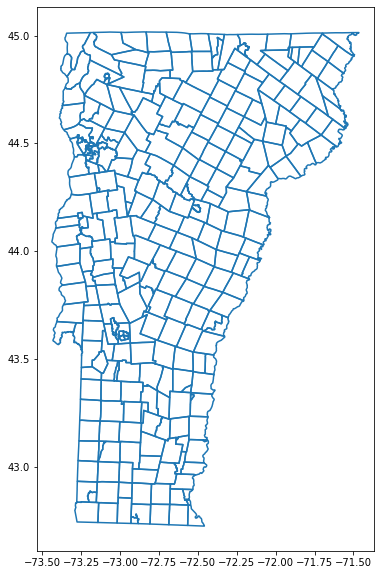

In [45]:
vest_vt_20.boundary.plot(figsize=(10,10))

### Import Census File

In [46]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Vermont"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

shp_list = []
for fips in list(fips_file["FIPS County"]):
    file_path = "./raw-from-source/Shapefiles/Census/tl_2020_50_all/tl_2020_50"+str(fips)+"_vtd20.shp"
    county_val = gp.read_file(file_path)
    shp_list.append(county_val)
#full_shapefiles_census = pd.concat(shp_list, axis=0, ignore_index=True)

DriverError: ./raw-from-source/Shapefiles/Census/tl_2020_50_all/tl_2020_50001_vtd20.shp: No such file or directory

<AxesSubplot:>

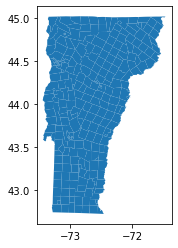

In [47]:
full_shapefiles_census.plot()

In [48]:
state_distr = gp.read_file("./raw-from-source/Shapefiles/VT_Data_-_Vermont_House_Districts_2012/VT_Data_-_Vermont_House_Districts_2012.shp")

#Grab needed columns
state_distr = state_distr[['DISTRICT','NAME','geometry']]

#Modify CRS
state_distr=state_distr.to_crs(vest_vt_20.crs)

county_sub = gp.read_file("./raw-from-source/Shapefiles/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics.shp")

#Grab columns
county_sub = county_sub[['COUNTYFP10','NAME10', 'NAMELSAD10','geometry']]

#Modify CRS
county_sub=county_sub.to_crs(vest_vt_20.crs)

<AxesSubplot:>

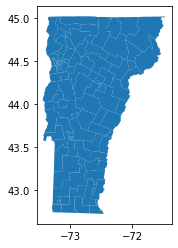

In [49]:
state_distr.plot()

In [50]:
fig = gp.overlay(state_distr,full_shapefiles_census, how="identity")
fig = fig.to_crs(vest_vt_20.crs)
print(fig.shape)

(1122, 18)


<ipython-input-50-945ef05277a9>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  fig = gp.overlay(state_distr,full_shapefiles_census, how="identity")


In [51]:
state_distr.columns

Index(['DISTRICT', 'NAME', 'geometry'], dtype='object')

In [52]:
full_shapefiles_census.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAMELSAD', 'VTDI', 'LSAD', 'CHNG_TYPE',
       'ORIG_NAME', 'ORIG_CODE', 'RELATE', 'NAME', 'VINTAGE', 'FUNCSTAT',
       'JUSTIFY', 'MTFCC', 'geometry'],
      dtype='object')

In [53]:
print(fig['NAME20'].value_counts(dropna=False))

KeyError: 'NAME20'

### Compare to VEST file

Aside from the handful of merges VEST mentions, these seem to match up

<AxesSubplot:>

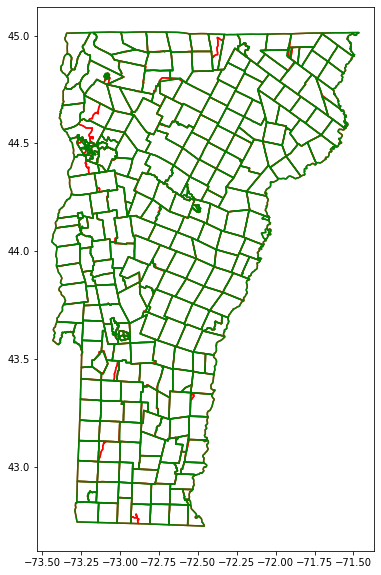

In [56]:
ax_2 = vest_vt_20.boundary.plot(figsize=(10,10),color="red")
full_shapefiles_census.boundary.plot(figsize=(10,10),ax=ax_2,color="green")

<AxesSubplot:>

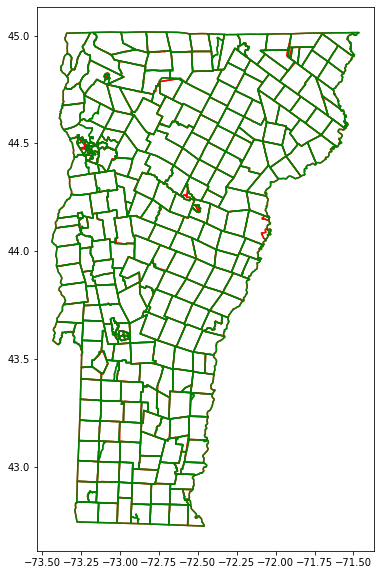

In [57]:
ax_2 = full_shapefiles_census.boundary.plot(figsize=(10,10),color="red")
vest_vt_20.boundary.plot(figsize=(10,10),ax=ax_2,color="green")

## Join Election Results to Shapefile

### Matching Names

In [61]:
full_shapefiles_census["NAMELSAD"].value_counts(dropna=False)

Ludlow Voting District          1
Dorset Voting District          1
Newbury Town Voting District    1
Rutland City Ward 2             1
Eden Voting District            1
                               ..
Wheelock Voting District        1
Whittingham Voting District     1
Montpelier District 1           1
Orange Voting District          1
Braintree Voting District       1
Name: NAMELSAD, Length: 285, dtype: int64

In [62]:
#Check number of rows and try to find a unique ID for each

print(full_shapefiles_census.shape)

print(frame.shape)
print(frame.columns)
print(len((full_shapefiles_census["NAMELSAD"]).unique()))
print(len((frame['NAME20']+frame['NAME20_1'].astype(str)).unique()))

#As you'll notice, there are 6 fewer election result columns

(285, 16)
(279, 52)
Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR',
       'G20LTGOWRI_to_add', 'G20LTGOWRI', 'G20GOVRSCO', 'G20GOVDZUC',
       'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL', 'G20GOVIDEV',
       'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI',
       'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES',
       'G20PREOOTH', 'G20PREOSAN', 'G20PREOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSISMI', 'G20SOSPERI', 'G20SOSOWRI', 'join_col'],
      dtype='object')
285
279


In [64]:
full_shapefiles_census["join_col"]=full_shapefiles_census["NAMELSAD"]
frame["NAME20_1"]=frame["NAME20_1"].fillna("")
frame["join_col"]=frame["NAME20"]+"-"+frame["NAME20_1"].astype(str)

In [65]:
frame["join_col"].to_csv("./election_unique_ID.csv")
full_shapefiles_census["join_col"].to_csv("./shapefile_unique_ID.csv")

### Change the names to match (look through dictionary to see typical string differences)

In [66]:
def precinct_merger(precinct_list,new_precinct):
    global full_shapefiles_census
    prec_holder = []
    for i in precinct_list:
        prec_holder.append(full_shapefiles_census.loc[full_shapefiles_census["join_col"]==i])
    new_geom = pd.concat(prec_holder, ignore_index=True).unary_union
    new_prec = gp.GeoDataFrame(geometry=[new_geom],columns=["geometry","join_col"],crs = full_shapefiles_census.crs)
    new_prec["join_col"]=new_precinct
    full_shapefiles_census = full_shapefiles_census.append(new_prec)
    full_shapefiles_census = full_shapefiles_census[~full_shapefiles_census["join_col"].isin(precinct_list)]

In [68]:
name_changes_dict = {'Addison Voting District':'Addison-',
'Albany Voting District':'Albany-',
'Alburgh Voting District':'Alburgh-',
'Andover Voting District':'Andover-',
'Artlington Voting District':'Arlington-',
'Athens Voting District':'Athens-',
'Bakersfield Voting District':'Bakersfield-',
'Baltimore Voting District':'Baltimore-',
'Barnard Voting District':'Barnard-',
'Barnet Voting District':'Barnet-',
'Barre Town Voting District':'Barre Town-',
'Barton Voting District':'Barton-',
'Belvidere Voting District':'Belvidere-',
'Bennignton District 1':'Bennington-Bennington 2-1',
'Bennington District 2':'Bennington-Bennington 2-2',
'Benson Voting District':'Benson-',
'Berkshire Voting District':'Berkshire-',
'Berlin Voting District':'Berlin-',
'Bethel Voting District':'Bethel-',
'Bloomfield Voting District':'Bloomfield-',
'Bolton Voting District':'Bolton-',
'Bradford Voting District':'Bradford-',
'Braintree Voting District':'Braintree-',
'Brandon Voting District':'Brandon-',
'Brattleboro District 1':'Brattleboro-Windham 2-1',
'Brattleboro District 2':'Brattleboro-Windham 2-2',
'Brattleboro District 3':'Brattleboro-Windham 2-3',
'Bridgewater Voting District':'Bridgewater-',
'Bridport Voting District':'Bridport-',
'Brighton Voting District':'Brighton-',
'Bristol Voting District':'Bristol-',
'Brookfield Voting District':'Brookfield-',
'Brookline Voting District':'Brookline-',
'Brownington Voting District':'Brownington-',
'Brunswick Voting District':'Brunswick-',
'Burke Voting District':'Burke-',
'Cabot Voting District':'Cabot-',
'Calais Voting District':'Calais-',
'Cambridge Voting District':'Cambridge-',
'Canaan Voting District':'Canaan-',
'Castleton Voting District':'Castleton-',
'Cavendish Voting District':'Cavendish-',
'Charleston Voting District':'Charleston-',
'Charlotte Voting District':'Charlotte-',
'Chelsea Voting District':'Chelsea-',
'Chester Voting District':'Chester-',
'Chittenden Voting District':'Chittenden-',
'Clarendon Voting District':'Clarendon-',
'Concord Voting District':'Concord-',
'Corinth Voting District':'Corinth-',
'Cornwall Voting District':'Cornwall-',
'Coventry Voting District':'Coventry-',
'Craftsbury Voting District':'Craftsbury-',
'Danby Voting District':'Danby-',
'Danville Voting District':'Danville-',
'Derby Voting District':'Derby-',
'Dorset Voting District':'Dorset-',
'Dover Voting District':'Dover-',
'Dummerston Voting District':'Dummerston-',
'Duxbury Voting District':'Duxbury-',
'East Haven Voting District':'E. Haven-',
'East Montpelier Voting District':'E. Montpelier-',
'Eden Voting District':'Eden-',
'Elmore Voting District':'Elmore-',
'Enosburgh Voting District':'Enosburgh-',
'Essex District 1':'Essex-Chittenden 8-1',
'Essex District 2':'Essex-Chittenden 8-2',
'Essex District 3':'Essex-Chittenden 8-3',
'Fair Haven Voting District':'Fair Haven-',
'Fairfax Voting District':'Fairfax-',
'Fairfield Voting District':'Fairfield-',
'Fairlee Voting District':'Fairlee-',
'Fayston Voting District':'Fayston-',
'Ferrisburgh Voting District':'Ferrisburgh-',
'Fletcher Voting District':'Fletcher-',
'Franklin Voting District':'Franklin-',
'Georgia Voting District':'Georgia-',
'Glover Voting District':'Glover-',
'Goshen Voting District':'Goshen-',
'Grafton Voting District':'Grafton-',
'Granby Voting District':'Granby-',
'Grand Isle Voting District':'Grand Isle-',
'Granville Voting District':'Granville-',
'Greensboro Voting District':'Greensboro-',
'Groton Voting District':'Groton-',
'Guildhall Voting District':'Guildhall-',
'Guilford Voting District':'Guilford-',
'Halifax Voting District':'Halifax-',
'Hancock Voting District':'Hancock-',
'Hardwick Voting District':'Hardwick-',
'Hartford District 1':'Hartford-Windsor 4-1',
'Hartford District 2':'Hartford-Windsor 4-2',
'Hartland Voting District':'Hartland-',
'Highgate Voting District':'Highgate-',
'Holland Voting District':'Holland-',
'Hubbardton Voting District':'Hubbardton-',
'Huntington Voting District':'Huntington-',
'Hyde Park Voting District':'Hyde Park-',
'Ira Voting District':'Ira-',
'Irasburg Voting District':'Irasburg-',
'Isle La Motte Voting District':'Isle La Motte-',
'Jamacia Voting District':'Jamaica-',
'Jay Voting District':'Jay-',
'Jericho Voting District':'Jericho-',
'Johnson Voting District':'Johnson-',
'Killington Voting District':'Killington-',
'Kirby Voting District':'Kirby-',
'Landgrove Voting District':'Landgrove-',
'Leicester Voting District':'Leicester-',
'Lemington Voting District':'Lemington-',
'Lincoln Voting District':'Lincoln-',
'Londonderry Voting District':'Londonderry-',
'Lowell Voting District':'Lowell-',
'Ludlow Voting District':'Ludlow-',
'Luneburg Voting District':'Lunenburg-',
'Lyndon Voting District':'Lyndon-',
'Maidstone Voting District':'Maidstone-',
'Manchester Voting District':'Manchester-',
'Marlboro Voting District':'Marlboro-',
'Marshfield Voting District':'Marshfield-',
'Mendon Voting District':'Mendon-',
'Middlebury Voting District':'Middlebury-',
'Middlesex Voting District':'Middlesex-',
'Middletown Springs Voting District':'Middletown Springs-',
'Monkton Voting District':'Monkton-',
'Montgomery Voting District':'Montgomery-',
'Mooretown Voting District':'Moretown-',
'Morgan Voting District':'Morgan-',
'Morristown Voting District':'Morristown-',
'Mount Holly Voting District':'Mount Holly-',
'Mount Tabor Voting District':'Mount Tabor-',
'New Haven Voting District':'New Haven-',
'Newark Voting District':'Newark-',
'Newfane Voting District':'Newfane-',
'Newport City Voting District':'Newport City-',
'Newport Town Voting District':'Newport Town-',
'North Hero Voting District':'N. Hero-',
'Northfield Voting District':'Northfield-',
'Norton Voting District':'Norton-',
'Norwich Voting District':'Norwich-',
'Orange Voting District':'Orange-',
'Orwell Voting District':'Orwell-',
'Panton Voting District':'Panton-',
'Pawlet Voting District':'Pawlet-',
'Peacham Voting District':'Peacham-',
'Peru Voting District':'Peru-',
'Pittsfield Voting District':'Pittsfield-',
'Pittsford Voting District':'Pittsford-',
'Plainfield Voting District':'Plainfield-',
'Plymouth Voting District':'Plymouth-',
'Pomfret Voting District':'Pomfret-',
'Poultney Voting District':'Poultney-',
'Pownal Voting District':'Pownal-',
'Proctor Voting District':'Proctor-',
'Putney Voting District':'Putney-',
'Randolph Voting District':'Randolph-',
'Reading Voting District':'Reading-',
'Readsboro Voting District':'Readsboro-',
'Richford Voting District':'Richford-',
'Richmond Voting District':'Richmond-',
'Ripton Voting District':'Ripton-',
'Rochester Voting District':'Rochester-',
'Rockingham Voting District':'Rockingham-',
'Roxbury Voting District':'Roxbury-',
'Royalton Voting District':'Royalton-',
'Rupert Voting District':'Rupert-',
'Rutland City Ward 1':'Rutland City-Rutland 5-1',
'Rutland City Ward 2':'Rutland City-Rutland 5-2',
'Rutland City Ward 3':'Rutland City-Rutland 5-3',
'Rutland City Ward 4':'Rutland City-Rutland 5-4',
'Rutland Town Voting District':'Rutland Town-',
'Ryegate Voting District':'Ryegate-',
'Salisbury Voting District':'Salisbury-',
'Sandgate Voting District':'Sandgate-',
'Searsburg Voting District':'Searsburg-',
'Shaftsbury Voting District':'Shaftsbury-',
'Sharon Voting District':'Sharon-',
'Sheffield Voting District':'Sheffield-',
'Sheldon Voting District':'Sheldon-',
'Shoreham Voting District':'Shoreham-',
'Shrewsbury Voting District':'Shrewsbury-',
'South Burlington District 1':'S. Burlington-Chittenden 7-1',
'South Burlington District 2':'S. Burlington-Chittenden 7-2',
'South Burlington District 3':'S. Burlington-Chittenden 7-3',
'South Burlington District 4':'S. Burlington-Chittenden 7-4',
'South Hero Voting District':'S. Hero-',
'St. Johnsbury Voting District':'St. Johnsbury-',
'Stamford Voting District':'Stamford-',
'Stannard Voting District':'Stannard-',
'Starksboro Voting District':'Starksboro-',
'Stockbridge Voting District':'Stockbridge-',
'Stowe Voting District':'Stowe-',
'Strafford Voting District':'Strafford-',
'Stratton Voting District':'Stratton-',
'Sudbury Voting District':'Sudbury-',
'Sutton Voting District':'Sutton-',
'Swanton Voting District':'Swanton-',
'Thetford Voting District':'Thetford-',
'Topsham Voting District':'Topsham-',
'Townshend Voting District':'Townshend-',
'Tunbridge Voting District':'Tunbridge-',
'Underhill Voting District':'Underhill-',
'Vergennes Voting District':'Vergennes-',
'Vernon Voting District':'Vernon-',
'Vershire Voting District':'Vershire-',
'Victory Voting District':'Victory-',
'Waitsfield Voting District':'Waitsfield-',
'Walden Voting District':'Walden-',
'Wallingford Voting District':'Wallingford-',
'Waltham Voting District':'Waltham-',
'Wardsboro Voting District':'Wardsboro-',
'Warren Voting District':'Warren-',
'Washington Voting District':'Washington-',
'Waterbury Voting District':'Waterbury-',
'Waterford Voting District':'Waterford-',
'Waterville Voting District':'Waterville-',
'Weathersfield Voting District':'Weathersfield-',
'West Fairlee Voting District':'W. Fairlee-',
'West Haven Voting District':'W. Haven-',
'West Rutland Voting District':'W. Rutland-',
'West Windsor Voting District':'W. Windsor-',
'Westfield Voting District':'Westfield-',
'Westford Voting District':'Westford-',
'Westmore Voting District':'Westmore-',
'Weston Voting District':'Weston-',
'Weybridge Voting District':'Weybridge-',
'Wheelock Voting District':'Wheelock-',
'Whiting Voting District':'Whiting-',
'Williamstown Voting District':'Williamstown-',
'Williston Voting District':'Williston-',
'Wilmington Voting District':'Wilmington-',
'Windham Voting District':'Windham-',
'Windsor Voting District':'Windsor-',
'Winhall Voting District':'Winhall-',
'Winooski Voting District':'Winooski-',
'Wolcott Voting District':'Wolcott-',
'Woodbury Voting District':'Woodbury-',
'Woodford Voting District':'Woodford-',
'Woodstock Voting District':'Woodstock-',
'Worcester Voting District':'Worcester-'}

In [73]:
full_shapefiles_census["join_col"] = full_shapefiles_census["join_col"].map(name_changes_dict).fillna(full_shapefiles_census["join_col"])

### Attempt to join

In [74]:
frame["join_col"].value_counts()

Tunbridge-                   1
Sheldon-                     1
Whitingham-Windham 6         1
Craftsbury-                  1
Stamford-                    1
                            ..
Buels Gore-                  1
Wolcott-                     1
Springfield-Windsor 3-1      1
Bennington-Bennington 2-1    1
Rochester-                   1
Name: join_col, Length: 279, dtype: int64

In [75]:
source_join = pd.merge(frame,full_shapefiles_census,how="outer",on="join_col",indicator=True)
print(source_join["_merge"].value_counts())

both          240
right_only     45
left_only      39
Name: _merge, dtype: int64


In [55]:
print(list(state_distr["NAME"]))

['Addison-1', 'Addison-2', 'Addison-3', 'Addison-4', 'Addison-5', 'Addison Rutland', 'Bennington-1', 'Bennington-2-1', 'Bennington-2-2', 'Bennington-3', 'Bennington-4', 'Bennington-Rutland', 'Caledonia-1', 'Caledonia-2', 'Caledonia-3', 'Caledonia-4', 'Caledonia-Washington', 'Chittenden-1', 'Chittenden-10', 'Chittenden-2', 'Chittenden-3', 'Chittenden-4-1', 'Chittenden-4-2', 'Chittenden-5-1', 'Chittenden-5-2', 'Chittenden-6-1', 'Chittenden-6-2', 'Chittenden-6-3', 'Chittenden-6-4', 'Chittenden-6-5', 'Chittenden-6-6', 'Chittenden-6-7', 'Chittenden-7-1', 'Chittenden-7-2', 'Chittenden-7-3', 'Chittenden-7-4', 'Chittenden-8-1', 'Chittenden-8-2', 'Chittenden-8-3', 'Chittenden-9-1', 'Chittenden-9-2', 'Essex-Caledonia', 'Essex-Caledonia-Orleans', 'Franklin-1', 'Franklin-2', 'Franklin-3-1', 'Franklin-3-2', 'Franklin-4', 'Franklin-5', 'Franklin-6', 'Franklin-7', 'Grand Isle-Chittenden', 'Lamoille-1', 'Lamoille-2', 'Lamoille-3', 'Lamoille-Washington', 'Orange-1', 'Orange-2', 'Orange-Caledonia', 'Ora

<AxesSubplot:>

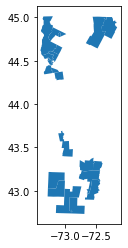

In [57]:


sub_list = ['Chittenden-6-1', 'Chittenden-6-2', 'Chittenden-6-3', 'Chittenden-6-4', 'Chittenden-6-5', 'Chittenden-6-6', 'Chittenden-6-7'
'Chittenden-4-1', 'Chittenden-4-2',
'Chittenden-9-1', 'Chittenden-9-2',
'Chittenden-10','Grand Isle-Chittenden',
'Chittenden-5-1', 'Chittenden-5-2',
'Windsor-3-1', 'Windsor-3-2',
'Franklin-3-1', 'Franklin-3-2',
'Bennington-3', 'Bennington-4',
'Rutland-2','Orleans-2','Orleans-Lamoille',
'Windham-3', 'Windham-4','Windham-6',
'Windham-Bennington']

state_distr[state_distr["NAME"].isin(sub_list)].plot()

<AxesSubplot:>

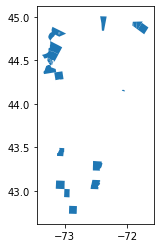

In [61]:
gp.GeoDataFrame(source_join[source_join["_merge"]=="right_only"]).plot()

In [49]:
print(source_join[source_join["_merge"]=="left_only"]["join_col"])

37         Burlington-Chittenden 6-1
38         Burlington-Chittenden 6-2
39         Burlington-Chittenden 6-3
40         Burlington-Chittenden 6-4
41         Burlington-Chittenden 6-5
42         Burlington-Chittenden 6-6
43         Burlington-Chittenden 6-7
56         Colchester-Chittenden 9-1
57         Colchester-Chittenden 9-2
104         Hinesburg-Chittenden 4-1
105         Hinesburg-Chittenden 4-2
136             Milton-Chittenden 10
137     Milton-Grand Isle-Chittenden
194         Shelburne-Chittenden 5-1
195         Shelburne-Chittenden 5-2
204          Springfield-Windsor 3-1
205          Springfield-Windsor 3-2
206                 St. Albans City-
207     St. Albans Town-Franklin 3-1
208     St. Albans Town-Franklin 3-2
219          Sunderland-Bennington 3
220          Sunderland-Bennington 4
224               Tinmouth-Rutland 2
225      Tinmouth-Rutland-Bennington
228                   Troy-Orleans 2
229            Troy-Orleans-Lamoille
254            Westminster-Windham 3
2

### Look into unjoined precincts

In [ ]:
print(source_join[source_join["_merge"]=="right_only"]["join_col"])

### Deal with no-vote precincts

Since VEST does not mention these in their documentation, nor a source for how they know when to allocate votes to precincts, we want to check whether it's reasonable to add these as no-vote precincts, without any vote allocation.

This is what VEST did, so this step is also verifying some of their work.

In [ ]:
acs_empty_precincts = pd.read_csv("./raw-from-source/ACS/Empty_Precincts/ACSST5Y2018.S0101_2021-05-24T115339/ACSST5Y2018.S0101_data_with_overlays_2021-05-24T115321.csv")

In [ ]:
acs_empty_precincts.columns = acs_empty_precincts.iloc[0]
acs_empty_precincts = acs_empty_precincts.drop([0])

#Filter to relevant columns
acs_empty_precincts = acs_empty_precincts[["Geographic Area Name","Estimate!!Total!!Total population","Margin of Error!!Total MOE!!Total population"]]

#Remove an area that was downloaded but not relevant to this analysis
acs_empty_precincts = acs_empty_precincts[acs_empty_precincts["Geographic Area Name"]!="Buels gore, Chittenden County, Vermont"]

#As you can see all of these 5 have a 0 population estimate, so it makes sense to add these as 0 pop. precincts
acs_empty_precincts

### Add the zero-vote precincts

In [ ]:
new_df = pd.DataFrame([["Avery's gore","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Avery's gore-ESX-CAL-ORL"],
                       ["Lewis town","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Lewis town-ESX-CAL-ORL"],
                       ["Warner's grant","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warner's grant-ESX-CAL-ORL"],
                       ["Warren's gore","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warren's gore-ESX-CAL-ORL"],
                       ["Somerset town","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Somerset town-WDH-BEN"]]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

### Attempt to join again

In [ ]:
source_join = pd.merge(frame,fig,how="outer",on="join_col",indicator=True)
print(source_join["_merge"].value_counts())

## Join Source File to VEST File

### Clean columns

In [ ]:
print(fig.head())

In [ ]:
print(vest_vt_20.columns)

In [ ]:
print(source_join.head())

In [ ]:
source_join = source_join[['COUNTYFP10',"NAME10","NAMELSAD10","DISTRICT","NAME",'G18USSISAN', 'G18USSRZUP', 'G18USSIPEA', 'G18USSIBES', 'G18USSIGIL',
       'G18USSIADE', 'G18USSISVI', 'G18USSIBUS', 'G18USSOKAN', 'G18USSOWRI',
       'G18HALDWEL', 'G18HALRTYN', 'G18HALIERI', 'G18HALOPOT', 'G18HALOWRI',
       'G18GOVDHAL', 'G18GOVRSCO', 'G18GOVIBAR', 'G18GOVILAR', 'G18GOVIERI',
       'G18GOVOMAR', 'G18GOVOPEY', 'G18GOVOWRI', 'G18LTGPZUC', 'G18LTGRTUR',
       'G18LTGONGO', 'G18LTGOWRI', 'G18ATGDDON', 'G18ATGRWIL', 'G18ATGOJAC',
       'G18ATGOWRI', 'G18SOSDCON', 'G18SOSRPAI', 'G18SOSOHEB', 'G18SOSOWRI',
       'G18TREDPEA', 'G18TRERMOR', 'G18TREOWRI', 'G18AUDDHOF', 'G18AUDRKEN',
       'G18AUDOBRO', 'G18AUDOWRI', 'geometry']]

### Define a unique ID for the final join

In [ ]:
source_join["final_join_col"]=source_join["NAMELSAD10"]+"-"+source_join["NAME"]+" State House District"

### Create a unique ID for VEST

In [ ]:
print(vest_vt_20.shape)
print(len((vest_vt_20["NAMELSAD"]+"-"+vest_vt_20["NAMELSAD_1"]).unique()))
vest_vt_20["final_join_col"]=vest_vt_20["NAMELSAD"]+"-"+vest_vt_20["NAMELSAD_1"]

In [ ]:
final_merge = pd.merge(vest_vt_20,source_join,how="outer",on="final_join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

### Modify Columns

In [ ]:
source_to_vest_changes_dict = {'Alburg town-Grand Isle-Chittenden State House District': 'Alburgh town-Grand-Isle-Chittenden State House District', 'Benson town-Addison Rutland State House District': 'Benson town-Addison-Rutland State House District', 'Enosburg town-Franklin-7 State House District': 'Enosburgh town-Franklin-7 State House District', 'Grand Isle town-Grand Isle-Chittenden State House District': 'Grand Isle town-Grand-Isle-Chittenden State House District', 'Isle La Motte town-Grand Isle-Chittenden State House District': 'Isle La Motte town-Grand-Isle-Chittenden State House District', 'Milton town-Grand Isle-Chittenden State House District': 'Milton town-Grand-Isle-Chittenden State House District', 'North Hero town-Grand Isle-Chittenden State House District': 'North Hero town-Grand-Isle-Chittenden State House District', 'Orwell town-Addison Rutland State House District': 'Orwell town-Addison-Rutland State House District', 'Shoreham town-Addison Rutland State House District': 'Shoreham town-Addison-Rutland State House District', 'South Hero town-Grand Isle-Chittenden State House District': 'South Hero town-Grand-Isle-Chittenden State House District', 'Whiting town-Addison Rutland State House District': 'Whiting town-Addison-Rutland State House District'}

source_join["final_join_col"] = source_join["final_join_col"].map(source_to_vest_changes_dict).fillna(source_join["final_join_col"])


In [ ]:
final_merge = pd.merge(vest_vt_20,source_join,how="outer",on="final_join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

## Validate Election Results

### County-by-county

The only difference is the one explained above with the 148 votes.

In [ ]:
diff_counties=[]
print("Counties with differences will be printed below:")
for i in data_columns:
    diff = source_join.groupby(["COUNTYFP10"]).sum()[i]-vest_vt_20.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

### Precinct-by-precinct

In [ ]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["final_join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["final_join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["final_join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [ ]:
validater_row(final_merge,data_columns)

The only difference is 1 vote allocated differently from how VEST does, this is likely a rounding difference.

## Validate Geometry

In [ ]:
print(final_merge.columns)

In [ ]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_vt_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_vt_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

In [ ]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,2]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

### Look into Warren's Gore & Norton Town Difference

Checking to see if there was a shapefile processing error on our end, and this does not seem to be the case.

In [ ]:
ax = state_distr[state_distr["NAME"]=="Essex-Caledonia-Orleans"].plot(color="red")
limits = county_sub[county_sub["NAME10"]=="Warren's"].total_bounds
xlim = ([limits[0],limits[2]])
ylim = ([limits[1],limits[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
county_sub[county_sub["NAME10"]=="Warren's"].exterior.plot(ax=ax,color="blue")

In [ ]:
ax = state_distr[state_distr["NAME"]=="Essex-Caledonia-Orleans"].plot(color="red")
limits = county_sub[county_sub["NAME10"]=="Norton"].total_bounds
xlim = ([limits[0],limits[2]])
ylim = ([limits[1],limits[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
county_sub[county_sub["NAME10"]=="Norton"].exterior.plot(ax=ax,color="blue")